In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity
from joblib import dump, load
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
print("# 1. Data Loading and Exploration")
df = pd.read_csv('movie.csv')
print(f"Dataset shape: {df.shape}")
print(df.head())

# 1. Data Loading and Exploration
Dataset shape: (6010, 7)
       director_name     actor_1_name      actor_2_name          actor_3_name  \
0      James Cameron      CCH Pounder  Joel David Moore             Wes Studi   
1     Gore Verbinski      Johnny Depp     Orlando Bloom        Jack Davenport   
2         Sam Mendes  Christoph Waltz      Rory Kinnear      Stephanie Sigman   
3  Christopher Nolan        Tom Hardy    Christian Bale  Joseph Gordon-Levitt   
4        Doug Walker      Doug Walker        Rob Walker               unknown   

                            genres  \
0  Action Adventure Fantasy Sci-Fi   
1         Action Adventure Fantasy   
2        Action Adventure Thriller   
3                  Action Thriller   
4                      Documentary   

                                         movie_title  \
0                                             avatar   
1           pirates of the caribbean: at world's end   
2                                            spectre   
3

In [3]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
director_name    0
actor_1_name     0
actor_2_name     0
actor_3_name     0
genres           0
movie_title      0
comb             0
dtype: int64


In [4]:
print("\n# 2. Feature Engineering for Clustering")
# Extract features from genres
def extract_genre_features(df):
    # Get all unique genres
    all_genres = set()
    for genres in df['genres']:
        if isinstance(genres, str):
            all_genres.update(genres.split())
    
    # Create binary columns for each genre
    for genre in sorted(all_genres):
        df[f'genre_{genre}'] = df['genres'].apply(lambda x: 1 if isinstance(x, str) and genre in x.split() else 0)
    
    return df


# 2. Feature Engineering for Clustering


In [5]:
# Apply feature extraction
df_features = extract_genre_features(df.copy())
print("Feature dataframe head:")
print(df_features.head())

Feature dataframe head:
       director_name     actor_1_name      actor_2_name          actor_3_name  \
0      James Cameron      CCH Pounder  Joel David Moore             Wes Studi   
1     Gore Verbinski      Johnny Depp     Orlando Bloom        Jack Davenport   
2         Sam Mendes  Christoph Waltz      Rory Kinnear      Stephanie Sigman   
3  Christopher Nolan        Tom Hardy    Christian Bale  Joseph Gordon-Levitt   
4        Doug Walker      Doug Walker        Rob Walker               unknown   

                            genres  \
0  Action Adventure Fantasy Sci-Fi   
1         Action Adventure Fantasy   
2        Action Adventure Thriller   
3                  Action Thriller   
4                      Documentary   

                                         movie_title  \
0                                             avatar   
1           pirates of the caribbean: at world's end   
2                                            spectre   
3                              the d

In [6]:
# Use TF-IDF on the combined features
tfidf = TfidfVectorizer(max_features=100, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['comb'].fillna(''))
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

In [7]:
# Combine with genre features
genre_columns = [col for col in df_features.columns if col.startswith('genre_')]
combined_features = pd.concat([tfidf_df, df_features[genre_columns].reset_index(drop=True)], axis=1)

In [8]:
print(f"\nFeature matrix shape: {combined_features.shape}")
print("Combined features head:")
print(combined_features.head())


Feature matrix shape: (6010, 130)
Combined features head:
     action  adam  adventure  alex  allen  andrew  animation  anne  anthony  \
0  0.243138   0.0   0.268449   0.0    0.0     0.0        0.0   0.0      0.0   
1  0.342180   0.0   0.377801   0.0    0.0     0.0        0.0   0.0      0.0   
2  0.373040   0.0   0.411873   0.0    0.0     0.0        0.0   0.0      0.0   
3  0.207310   0.0   0.000000   0.0    0.0     0.0        0.0   0.0      0.0   
4  0.000000   0.0   0.000000   0.0    0.0     0.0        0.0   0.0      0.0   

   ben  ...  genre_Reality-TV  genre_Romance  genre_Sci-Fi  genre_Science  \
0  0.0  ...                 0              0             1              0   
1  0.0  ...                 0              0             0              0   
2  0.0  ...                 0              0             0              0   
3  0.0  ...                 0              0             0              0   
4  0.0  ...                 0              0             0              0   

   

In [9]:
print("\n# 3. Dimensionality Reduction with PCA")
# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_features)


# 3. Dimensionality Reduction with PCA


In [10]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Retain 95% of variance
pca_features = pca.fit_transform(scaled_features)

In [11]:
print(f"Original dimensions: {scaled_features.shape[1]}")
print(f"Reduced dimensions: {pca_features.shape[1]}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")

Original dimensions: 130
Reduced dimensions: 96
Explained variance ratio: 0.9521


In [12]:
print("\n# 4. Finding Optimal Number of Clusters")
# Elbow Method
inertia = []
silhouette_scores = []
k_range = range(2, 21)


# 4. Finding Optimal Number of Clusters


In [13]:
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(pca_features)
    inertia.append(kmeans.inertia_)
    
    # Calculate silhouette score
    if k > 1:  # Silhouette score requires at least 2 clusters
        silhouette_avg = silhouette_score(pca_features, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)
    else:
        silhouette_scores.append(0)

In [14]:
# Plot the Elbow Method
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

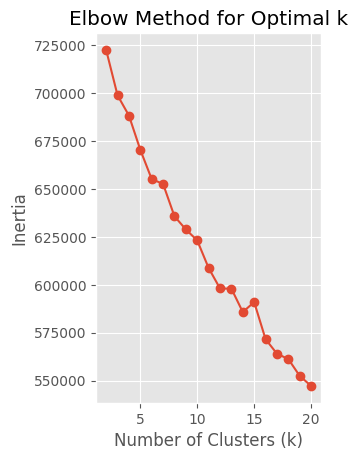

In [15]:
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)

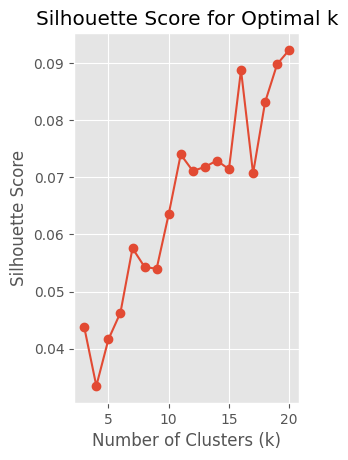

In [16]:
plt.subplot(1, 2, 2)
plt.plot(k_range[1:], silhouette_scores[1:], 'o-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.grid(True)

In [17]:
plt.tight_layout()
plt.savefig('elbow_method.png')
print("Elbow method plot saved as 'elbow_method.png'")

Elbow method plot saved as 'elbow_method.png'


<Figure size 640x480 with 0 Axes>

In [18]:
print("\nBased on the elbow method and silhouette score analysis, choosing optimal k...")
# Choose k based on elbow method
optimal_k = 10  # This should be adjusted based on the elbow plot
print(f"Selected optimal_k = {optimal_k}")


Based on the elbow method and silhouette score analysis, choosing optimal k...
Selected optimal_k = 10


In [19]:
# Apply KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(pca_features)

In [20]:
# Add cluster labels to the original dataframe
df['cluster'] = cluster_labels

Cluster distribution plot saved as 'cluster_distribution.png'


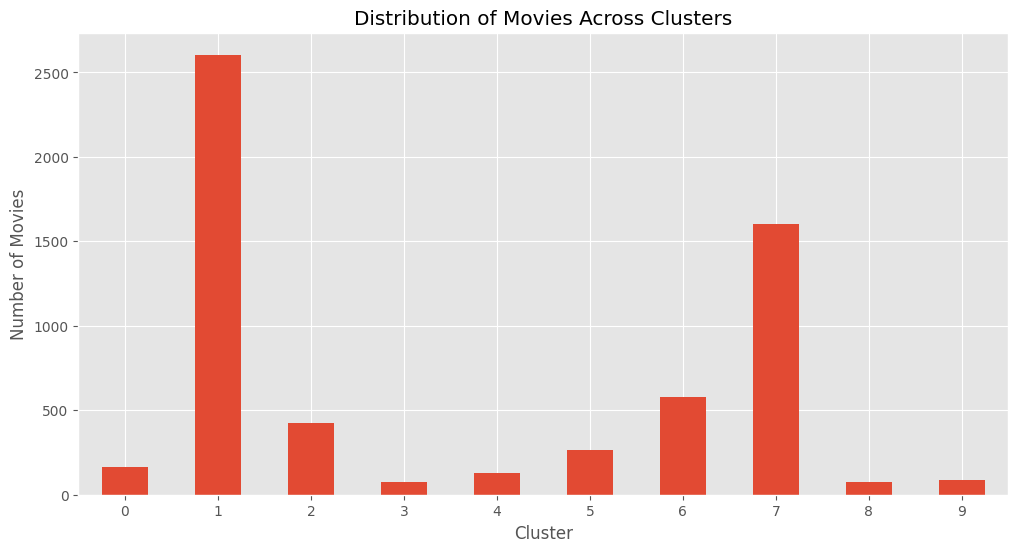

In [21]:
# Distribution of movies across clusters
plt.figure(figsize=(12, 6))
cluster_counts = df['cluster'].value_counts().sort_index()
cluster_counts.plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movies Across Clusters')
plt.xticks(rotation=0)
plt.savefig('cluster_distribution.png')
print("Cluster distribution plot saved as 'cluster_distribution.png'")

In [22]:
print("\n# 5. Visualizing Clusters")
# Visualize clusters in 2D using PCA
pca_2d = PCA(n_components=2)
pca_2d_data = pca_2d.fit_transform(pca_features)


# 5. Visualizing Clusters


In [23]:
# Create a dataframe for plotting
plot_df = pd.DataFrame({
    'x': pca_2d_data[:, 0],
    'y': pca_2d_data[:, 1],
    'cluster': cluster_labels,
    'title': df['movie_title']
})

Cluster visualization plot saved as 'cluster_visualization.png'


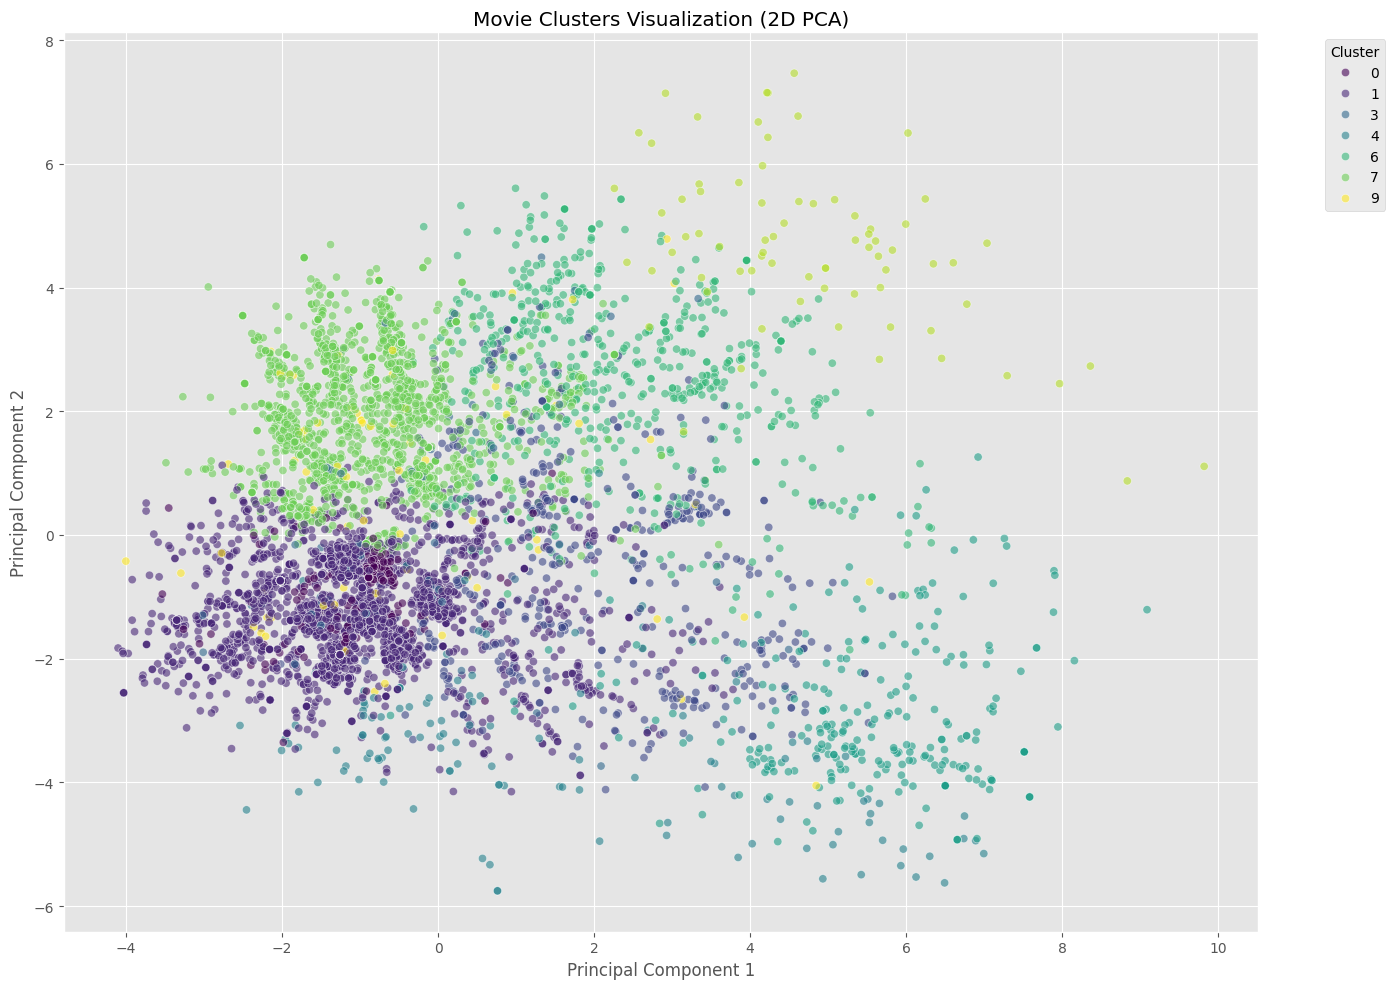

In [24]:
# Plot clusters
plt.figure(figsize=(14, 10))
sns.scatterplot(data=plot_df, x='x', y='y', hue='cluster', palette='viridis', alpha=0.6)
plt.title('Movie Clusters Visualization (2D PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('cluster_visualization.png')
print("Cluster visualization plot saved as 'cluster_visualization.png'")

In [25]:
print("\n# 6. Analyzing Cluster Characteristics")
# Analyze the genres distribution in each cluster
genre_columns = [col for col in df_features.columns if col.startswith('genre_')]
cluster_genre_profile = df_features.groupby(df['cluster'])[genre_columns].mean()


# 6. Analyzing Cluster Characteristics


Genre distribution heatmap saved as 'genre_distribution.png'


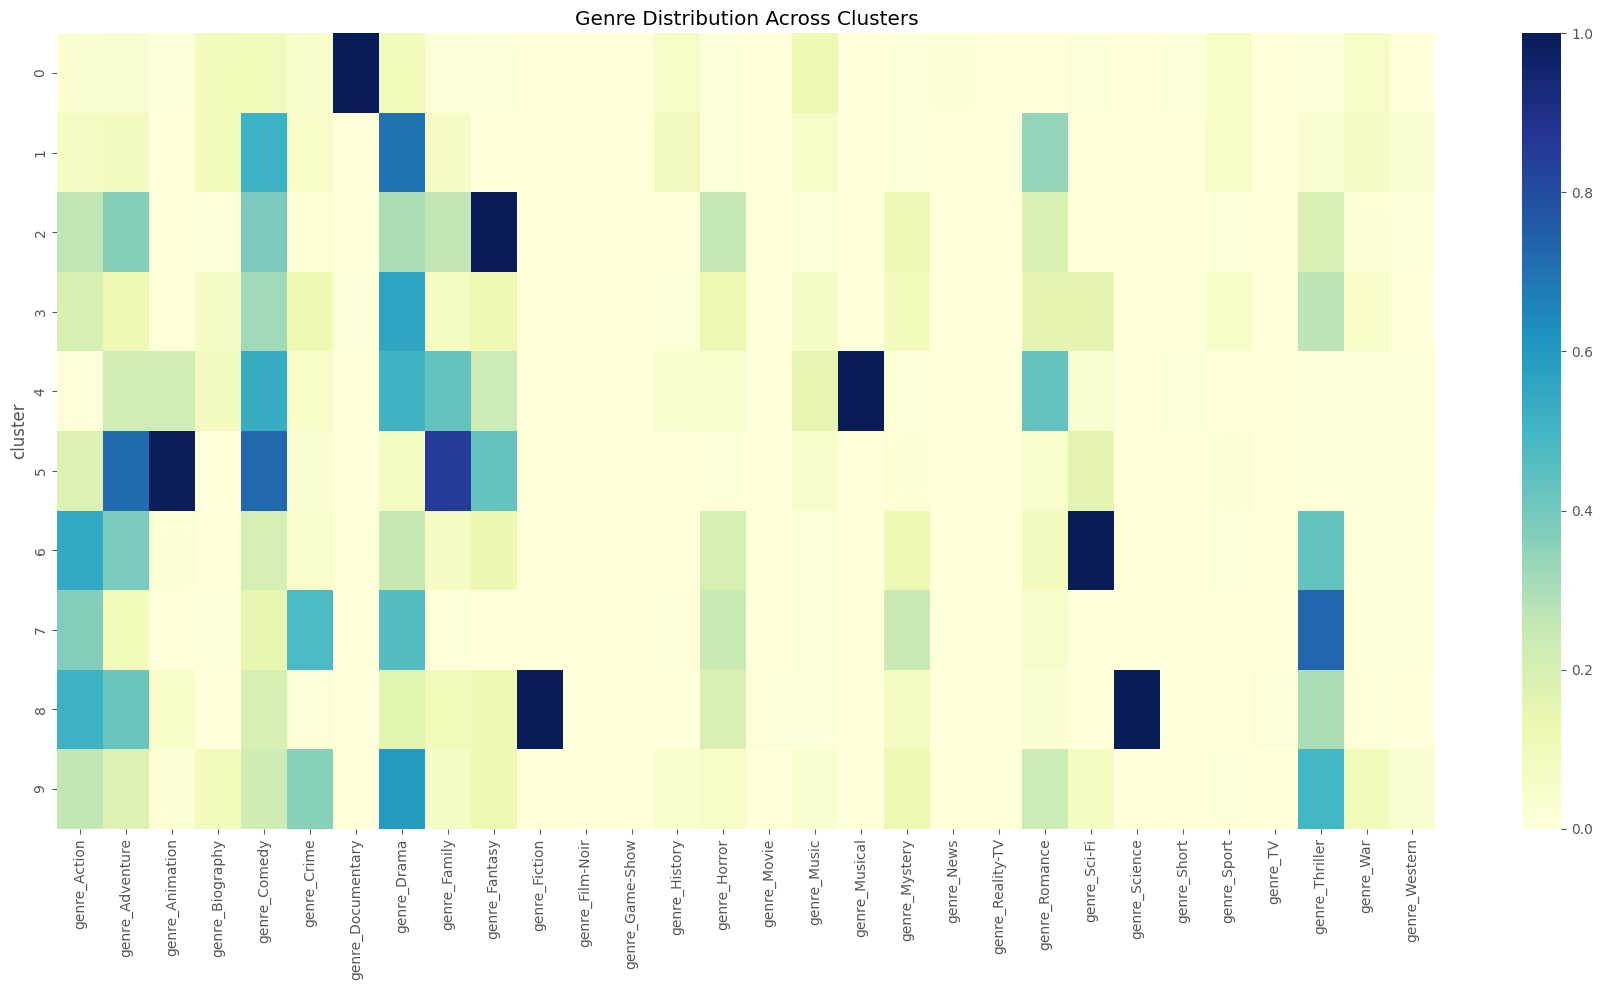

In [26]:
# Plot heatmap of genre distribution across clusters
plt.figure(figsize=(18, 10))
sns.heatmap(cluster_genre_profile, cmap='YlGnBu', annot=False)
plt.title('Genre Distribution Across Clusters')
plt.tight_layout()
plt.savefig('genre_distribution.png')
print("Genre distribution heatmap saved as 'genre_distribution.png'")

In [27]:
# Find top genres for each cluster
top_genres_per_cluster = {}
for cluster in range(optimal_k):
    # Get genre distribution for this cluster
    cluster_profile = cluster_genre_profile.loc[cluster]
    # Sort genres by their importance in this cluster
    top_genres = cluster_profile.sort_values(ascending=False).head(5)
    # Store top 5 genres and their scores for this cluster
    top_genres_per_cluster[cluster] = dict(top_genres)

In [28]:
# Print top genres for each cluster
print("\nTop genres for each cluster:")
for cluster, genres in top_genres_per_cluster.items():
    print(f"Cluster {cluster} Top Genres:")
    for genre, score in genres.items():
        print(f"  {genre.replace('genre_', '')}: {score:.3f}")
    print()


Top genres for each cluster:
Cluster 0 Top Genres:
  Documentary: 1.000
  Music: 0.128
  Comedy: 0.098
  Drama: 0.091
  Biography: 0.091

Cluster 1 Top Genres:
  Drama: 0.697
  Comedy: 0.513
  Romance: 0.342
  Biography: 0.091
  History: 0.089

Cluster 2 Top Genres:
  Fantasy: 1.000
  Comedy: 0.385
  Adventure: 0.366
  Drama: 0.298
  Action: 0.262

Cluster 3 Top Genres:
  Drama: 0.560
  Comedy: 0.320
  Thriller: 0.267
  Action: 0.200
  Romance: 0.160

Cluster 4 Top Genres:
  Musical: 1.000
  Comedy: 0.534
  Drama: 0.511
  Family: 0.427
  Romance: 0.427

Cluster 5 Top Genres:
  Animation: 0.989
  Family: 0.848
  Comedy: 0.726
  Adventure: 0.719
  Fantasy: 0.430

Cluster 6 Top Genres:
  Sci-Fi: 1.000
  Action: 0.546
  Thriller: 0.430
  Adventure: 0.386
  Drama: 0.251

Cluster 7 Top Genres:
  Thriller: 0.729
  Crime: 0.479
  Drama: 0.464
  Action: 0.369
  Mystery: 0.247

Cluster 8 Top Genres:
  Fiction: 1.000
  Science: 1.000
  Action: 0.514
  Adventure: 0.419
  Thriller: 0.297

Cluster 

In [29]:
print("\n# 7. Implementing the Cluster-Based Recommender Function")
def cluster_based_recommend(movie_title, n_recommendations=10):
    """Generate movie recommendations based on cluster membership"""
    movie_title = movie_title.lower()
    
    # Check if the movie exists in our dataset
    if movie_title not in df['movie_title'].str.lower().values:
        return f"Movie '{movie_title}' not found in the dataset."
    
    # Get the movie's index and cluster
    movie_idx = df[df['movie_title'].str.lower() == movie_title].index[0]
    movie_cluster = df.loc[movie_idx, 'cluster']
    
    # Get other movies from the same cluster
    cluster_movies = df[df['cluster'] == movie_cluster].copy()
    
    # Remove the input movie from recommendations
    cluster_movies = cluster_movies[cluster_movies.index != movie_idx]
    
    # Get the input movie's features
    movie_features = pca_features[movie_idx].reshape(1, -1)
    
    # Get features for all movies in the same cluster
    cluster_indices = cluster_movies.index.tolist()
    cluster_features = pca_features[cluster_indices]
    
    # Calculate similarity
    similarities = cosine_similarity(movie_features, cluster_features).flatten()
    
    # Add similarity scores to the cluster movies dataframe
    cluster_movies['similarity'] = similarities
    
    # Sort by similarity
    recommendations = cluster_movies.sort_values('similarity', ascending=False)
    
    # Return top n recommendations
    return recommendations[['movie_title', 'similarity', 'genres']].head(n_recommendations)


# 7. Implementing the Cluster-Based Recommender Function


In [30]:
# Test the recommender function
test_movie = "avatar"  # Use a movie from your dataset
recommendations = cluster_based_recommend(test_movie, 10)
print(f"Recommendations for '{test_movie}':")
print(recommendations)

Recommendations for 'avatar':
                                    movie_title  similarity  \
1743  spy kids: all the time in the world in 4d    0.779616   
1760                                 flatliners    0.719249   
888                                     super 8    0.717294   
1626                      dragonball: evolution    0.602836   
337                a.i. artificial intelligence    0.563688   
3209                                 barbarella    0.557648   
84                      guardians of the galaxy    0.549728   
4464                               the specials    0.548685   
1059                                       dune    0.544583   
3506  beastmaster 2: through the portal of time    0.530485   

                                        genres  
1743     Action Adventure Comedy Family Sci-Fi  
1760              Drama Horror Sci-Fi Thriller  
888                    Mystery Sci-Fi Thriller  
1626  Action Adventure Fantasy Sci-Fi Thriller  
337                     Adventu

In [31]:
print("\n# 8. Saving the Cluster Model for API Integration")
# Create a dictionary with all necessary components for the model
cluster_model = {
    'kmeans': kmeans,
    'pca': pca,
    'scaler': scaler,
    'tfidf': tfidf,
    'pca_features': pca_features,
    'movie_data': df[['movie_title', 'cluster', 'genres']]
}


# 8. Saving the Cluster Model for API Integration


In [32]:
# Save model components
dump(cluster_model, 'cluster_model.joblib')
print("Cluster model saved as 'cluster_model.joblib'")

Cluster model saved as 'cluster_model.joblib'


In [33]:
print("\n# 9. Comparing Content-Based and Cluster-Based Recommendations")
# Load the content-based model
try:
    movies_dict = load(open('movies_dict.joblib', 'rb'))
    similarity = load(open('similarity.joblib', 'rb'))
    movies_df = pd.DataFrame(movies_dict)

    def content_based_recommend(movie_title, n_recommendations=10):
        """Generate movie recommendations based on content similarity"""
        movie_title = movie_title.lower()
        
        # Check if the movie exists in our dataset
        if movie_title not in movies_df['movie_title'].values:
            return f"Movie '{movie_title}' not found in the dataset."
        
        # Get the movie's index
        movie_idx = movies_df[movies_df['movie_title'] == movie_title].index[0]
        
        # Get similarity scores
        distances = similarity[movie_idx]
        
        # Get similar movies (excluding the input movie)
        movies_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x: x[1])[1:n_recommendations+1]
        
        # Create a recommendations dataframe
        recommendations = pd.DataFrame(
            [(movies_df.iloc[i[0]].movie_title, i[1], movies_df.iloc[i[0]].genres) for i in movies_list],
            columns=['movie_title', 'similarity', 'genres']
        )
        
        return recommendations

    # Compare recommendations
    test_movie = "avatar"
    print("Content-Based Recommendations:")
    content_recs = content_based_recommend(test_movie)
    print(content_recs)
    
    print("\nCluster-Based Recommendations:")
    cluster_recs = cluster_based_recommend(test_movie)
    print(cluster_recs)
    
    # Calculate overlap between recommendations
    content_titles = set(content_recs['movie_title'])
    cluster_titles = set(cluster_recs['movie_title'])
    common_titles = content_titles.intersection(cluster_titles)
    
    print(f"\nNumber of common recommendations: {len(common_titles)}")
    print(f"Overlap percentage: {len(common_titles) / len(content_titles) * 100:.2f}%")
    print("\nCommon recommendations:")
    for title in common_titles:
        print(f"- {title}")

    print("\n# 10. Implementing Hybrid Recommendations")
    def hybrid_recommend(movie_title, n_recommendations=10, content_weight=0.5):
        """Generate hybrid recommendations by combining content-based and cluster-based approaches"""
        movie_title = movie_title.lower()
        
        # Get recommendations from both approaches
        content_recs = content_based_recommend(movie_title, n_recommendations=20)
        cluster_recs = cluster_based_recommend(movie_title, n_recommendations=20)
        
        if isinstance(content_recs, str) or isinstance(cluster_recs, str):
            return "Movie not found in one or both datasets."
        
        # Create dictionaries with scores
        content_scores = dict(zip(content_recs['movie_title'], content_recs['similarity']))
        cluster_scores = dict(zip(cluster_recs['movie_title'], cluster_recs['similarity']))
        
        # Combine all unique movies
        all_movies = set(content_scores.keys()).union(set(cluster_scores.keys()))
        
        # Calculate hybrid scores
        hybrid_scores = {}
        for movie in all_movies:
            content_score = content_scores.get(movie, 0)
            cluster_score = cluster_scores.get(movie, 0)
            hybrid_scores[movie] = content_weight * content_score + (1 - content_weight) * cluster_score
        
        # Sort by hybrid score
        sorted_hybrid = sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)
        
        # Create recommendations dataframe
        recommendations = pd.DataFrame(sorted_hybrid[:n_recommendations], columns=['movie_title', 'hybrid_score'])
        
        # Add genre information
        movie_to_genre = dict(zip(df['movie_title'], df['genres']))
        recommendations['genres'] = recommendations['movie_title'].map(movie_to_genre)
        
        return recommendations

    # Test the hybrid recommender
    hybrid_recs = hybrid_recommend(test_movie, content_weight=0.6)
    print("\nHybrid Recommendations:")
    print(hybrid_recs)

    print("\n# 11. Save Final Models for API Integration")
    # Package all models and functions for the API
    recommendation_models = {
        'cluster_model': cluster_model,
        'movies_with_clusters': df[['movie_title', 'cluster', 'genres']].to_dict(),
        'pca_features': pca_features
    }

    # Save combined model
    dump(recommendation_models, 'recommendation_models.joblib')
    print("Final model saved as 'recommendation_models.joblib'")
except Exception as e:
    print(f"Content-based model couldn't be loaded: {e}")
    print("Saving only the cluster model components...")
    # Package all models and functions for the API
    recommendation_models = {
        'cluster_model': cluster_model,
        'movies_with_clusters': df[['movie_title', 'cluster', 'genres']].to_dict(),
        'pca_features': pca_features
    }
    # Save combined model
    dump(recommendation_models, 'recommendation_models.joblib')
    print("Final model saved as 'recommendation_models.joblib'")


# 9. Comparing Content-Based and Cluster-Based Recommendations
Content-Based Recommendations:
Content-based model couldn't be loaded: 'Series' object has no attribute 'genres'
Saving only the cluster model components...
Final model saved as 'recommendation_models.joblib'
